# Anomaly Detection and Recommender Systems

Hey there, hi there, ho there, dear reader! Today we will be implementing anomaly detection and recommender system algorithms based on Andrew Ng’s machine learning class (https://www.coursera.org/learn/machine-learning), first from scratch and then in scikit learn. Anomaly detection simply means using a Gaussian (or normal) distribution to find abnormal data points. Meanwhile, recommendor algorithms make use of the collaborative filtering algorithm and low-rank matrix factorization. Both anomaly detection and recommender systems are examples of unsupervised learning algorithms.

Anyway, let’s get started and load in our favorite data science libraries!

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline
#set default figure size
mpl.rcParams['figure.figsize'] = (12, 8)

Andrew Ng:

In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected $m = 307$ examples of how they were behaving, and thus have an unlabeled dataset $ \{x^{(1)}, ..., x^{(m)}\}$. You suspect that the vast majority of these examples are "normal" (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your dataset. You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing. On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions.

Okay then! Let's load up the dat an see how much trouble we're in.

In [2]:
data1 = loadmat('data/ex8data1.mat')
X1 = data1['X']
print('X1: {0}'.format(X1.shape))

X1: (307, 2)


Let's write up a plotting function. We're first just going to want to take a look at the data. After that though, we need to draw a contour plot and then finally we will need to be able to detect and visualize our outliers or abnormal data points.

In [3]:
def plotData(X, mu = np.array([0, 0]), sigma2 = 0, epsilon = 0):
    plt.figure(figsize=(12, 8))
    plt.scatter(X[:, 0],X[:, 1], marker = 'x', label = "Data")
    plt.title("Outlier detection")
    plt.xlabel("Latency (ms)")
    plt.ylabel("Throughput (mb/s)")
    plt.grid(True)
    
    if mu.any() != 0:
        xx, yy = np.meshgrid(np.linspace(0, 30, 100), np.linspace(0, 30, 100))
        p = gaussian(np.hstack((xx.ravel()[:, np.newaxis], yy.ravel()[:, np.newaxis])), mu, sigma2)
        levels = np.array(([10**i for i in np.arange(-20, 0, 3, dtype = np.float)])).T
        CS = plt.contour(xx, yy, p[:, np.newaxis].reshape(xx.shape), levels, cmap = 'PRGn_r')
        plt.clabel(CS, inline = 1, fontsize = 10)
        for i, label in enumerate(CS.cvalues):
               CS.collections[i].set_label(label)
    
    if epsilon != 0:
        pdf = gaussian(X, mu, sigma2)
        outliers = np.where(pdf < epsilon)
        plt.scatter(X[outliers[0], 0], X[outliers[0], 1], marker = "o", facecolor = "none", 
                    edgecolor = "red", s = 150, label = "Outliers")
    
    plt.legend()

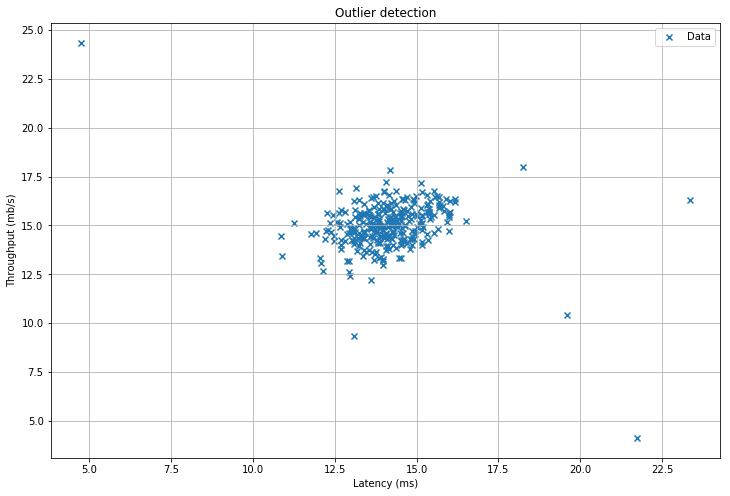

In [4]:
plotData(X1)

As you can see above, the vast majority of the data is right around the center, and these would the data points we consider to be "normal". However, as Professor Ng hinted at, there do appear to be some outliers, which in this example, would be servers acting weird. Time to detect some anomolies!

Given a training set $ \{x^{(1)}, ..., x^{(m)}\}$ (where $x^{(1)} \in {\rm I\!R^{n}}$) ($x$ is a real number), we want to estimate the Gaussian distribution for each of the features $x_i$. For each feature $i = 1 ... n$, we need to find parameters $\mu_i$ (the mean) and $\sigma_i^2$ (the variance) that fit the data in the $i$-th dimension $ \{x^{(1)}, ..., x^{(m)}\}$ ($i$-th dimension of each example. The Gaussian Distribution is also known as the normal distribution, which is also known as the bell curve!

### Gaussian Distribution

We define the Gaussian Distribution as

$$p(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{(x-\mu)^2}{2\sigma^2}}$$

where $\mu$ is the mean and is estimated by
$$\mu_i = \frac{1}{m}\sum^m_{j=1}x^{(j)}$$

while $\sigma^2$ is the variance which we estimate by using
$$\sigma^2_i = \frac{1}{m}\sum^m_{j=1}(x^{(j)} - \mu_j)^2$$

If you're curious $\sigma$ is called the standard deviation and is calculated using this equation:

$$\sigma_i = \sqrt{\frac{1}{m}\sum^m_{j=1}(x^{(j)} - \mu_j)}$$

We won't being the standard deviation in the exercise, but it's good to know!

Calculating the mean and variance is thankfully fairly trivial, and numpy is happy to help out!

In [5]:
def meanVariance(X):
    mu = np.mean(X, axis = 0)
    sigma2 = np.var(X, ddof = 1, axis = 0)
        
    return mu, sigma2

In [7]:
mu, sigma2 = meanVariance(X1)
print("Mean: {0}".format(mu))
print("Variance: {0}".format(sigma2))

Mean: [14.11222578 14.99771051]
Variance: [1.83862041 1.71533273]


### Multivariate Gaussian Distribution

We will also need to the Multivariate Gaussian Distribution to be able to draw the contour lines. This distribution is given by

$$p(x;\mu,\Sigma) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}} exp(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu))$$

This is a doozy. Wish me luck.

In [8]:
def gaussian(X, mu, sigma2):
       
    sigma2 = np.diag(sigma2)
    X = X - mu.T
    
    pdf = 1 / ((2 * np.pi)**(len(mu) / 2) * (np.linalg.det(sigma2)**(1/2))) * \
          np.exp((-1/2) * np.sum(X @ np.linalg.pinv(sigma2) * X, axis = 1))
    
    return pdf

Unless I make a mistake, we should be able to plot our contour lines now.

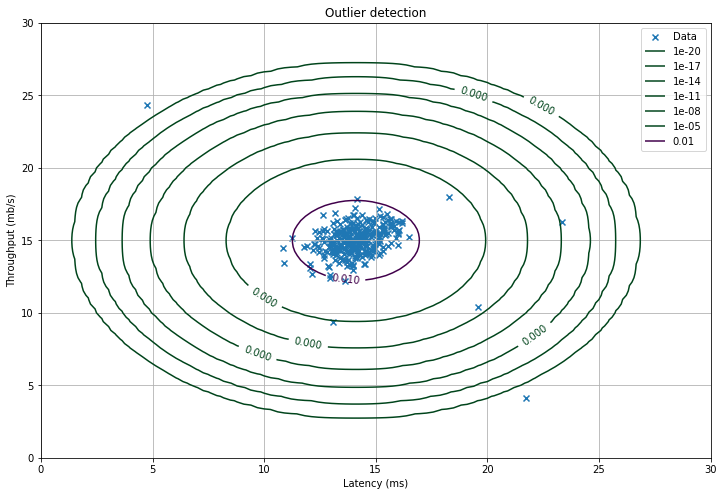

In [9]:
mu, sigma2 = meanVariance(X1)
plotData(X1, mu, sigma2)

Great! As you can see, the distribution captures the majority of the data right in the center, while there are only a few data points outside the purple contour, which represents higher probability. The other points occur with such low probabilty that the contour descriminator has pushed it basically to zero, denoted by green contours.

Let's load up the validation data which we will use to evaluate our model with standard data science/machine learning metrics.

In [11]:
Xval1 = data1['Xval']
yval1 = data1['yval']

print("Xval1: {0}".format(Xval1.shape))
print("yval1: {0}".format(yval1.shape))

Xval1: (307, 2)
yval1: (307, 1)


### Selecting the threshold  $\epsilon$
One way to determine which examples are anomalies is to select a threshold based on a cross validation set.  Now we can implement an algorithm to select the threshold $\epsilon$ using the $F1$ score on a cross validation set. For this, we
will use a cross validation set $\{(x^{(1)}_{cv}, y^{(1)}_{cv}), ..., (x^{(m_{cv})}_{cv}, y^{(m_{cv})}_{cv})\}$ where the label $y = 1$ corresponds to an anomalous example, and $y = 0$ corresponds to a normal example. For each cross validation example, we will compute $p(x^{(i)}_{cv})$, the probabilty of a given cross validation example occuring. We can then pass a vector of all of these probabilities $p(x^{(i)}_{cv}, ..., p(x^{(m_{cv})}_{cv})$ to a new function called selectThreshold as the vector pval. The corresponding labels $y^{(1)}_{cv}, ..., y^{(m_{cv})}_{cv}$ will then also be passed to selectThreshold as the vector yval.

We want this function to return two values. This first value is $\epsilon$, the threshold. If some $x$ has a low probabilty ($p(x) < \epsilon$), then we'll say it's an anomaly. The second value we want to return if the $F1$ score. We compute this score by first computing precision and recall. 

$$ precision = \frac{tp}{tp+fp}$$

$$ recall = \frac{tp}{tp+fn}$$

$tp$ is the number of true positives: the ground truth label says it's an anomaly and our algorithm correctly classified it as an anomaly.

$fp$ is the number of false positives: the ground truth label says it's not an anomaly, but our algorithm incorrectly classified it as an anomaly.

$fn$ is the number of false negatives: the ground truth label says it's an anomaly, but our algorithm incorrectly classified it as not being anomalous.

We can then compute $F1$, which is also called the harmonic mean of precision and recall.

$$ F1 = \frac{2 \cdot precision\cdot recall}{precision+ recall}$$

That was a mouthful! Here we go.

In [12]:
def selectThreshold(pval, yval):
    best_epi = 0; best_f1 = 0
    
    step = (max(pval) - min(pval)) / 1000
    for epi in np.arange(pval.min(), pval.max(), step):
        preds = (pval < epi)[:, np.newaxis]
        tp = np.sum(preds[yval == 1] == 1)
        fp = np.sum(preds[yval == 0] == 1)
        fn = np.sum(preds[yval == 1] == 0)
        
        # compute precision, recall and F1
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        f1 = (2 * precision * recall) / (precision + recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epi = epi
        
    return best_epi, best_f1

In [13]:
pval = gaussian(Xval1, mu, sigma2)
epsilon, F1 = selectThreshold(pval, yval1)
print("Best epsilon: {0}".format(epsilon))
print("Best F1 on Cross Validation Set: {0}".format(F1))

Best epsilon: 8.961567687193517e-05
Best F1 on Cross Validation Set: 0.8750000000000001


C:\Users\Theochem\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


Looks good! With epsilon at hand, we can now flag those pesky outliers.

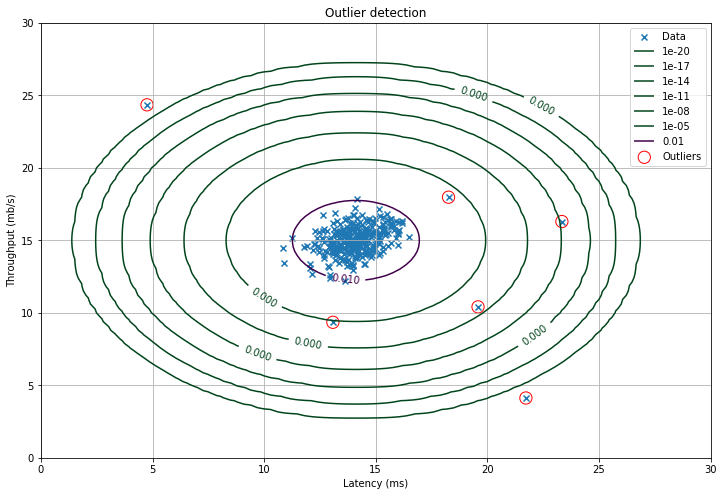

In [14]:
plotData(X1, mu, sigma2, epsilon)

Nice! Of course, scikit learn could've done this for us as well. Let me show you!

### Outlier Detection with Scikit Learn

In [15]:
from sklearn.covariance import EllipticEnvelope
clf = EllipticEnvelope()
clf.fit(X1)

EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=None,
         store_precision=True, support_fraction=None)

In [16]:
xx, yy = np.meshgrid(np.linspace(0, 30, 100), np.linspace(0, 30, 100))
z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)
y_pred = clf.decision_function(X1).ravel()
threshold = np.percentile(y_pred, 1.95)
outliers = y_pred < threshold

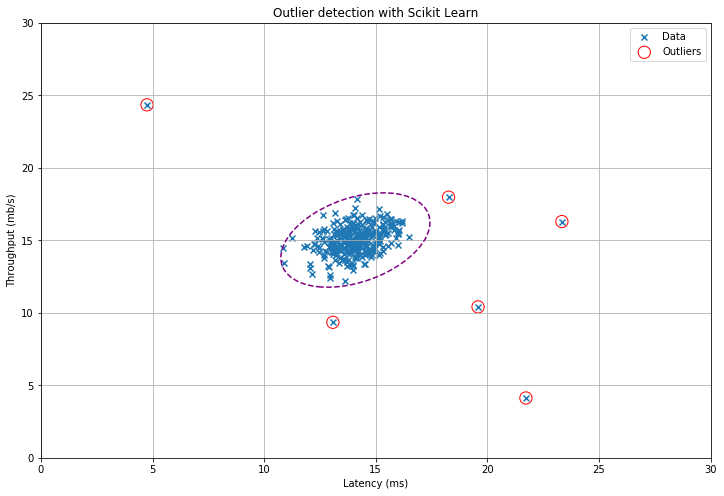

In [18]:
plt.figure(figsize=(12, 8))
plt.scatter(X1[:, 0], X1[:, 1], marker = 'x', label = "Data")
plt.scatter(X1[outliers][:, 0], X1[outliers][:, 1], marker = "o", facecolor = "none", 
                    edgecolor = "red", s = 150, label = "Outliers")
plt.contour(xx, yy, z, levels = [threshold], colors = 'purple')
plt.title("Outlier detection with Scikit Learn")
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.grid(True)
plt.legend()

We could even get the same probability fit if we were to play with the parameters for a while. However, as you can see, scikit learn found all the same outliers! Anyway, onto the second problem!

### High dimensional dataset

Let's load up our new data and rerun the code to see what we get when using a higher dimensional dataset that cannot be visualized.

In [20]:
data2 = loadmat('data/ex8data2.mat')
X2 = data2['X']
Xval2 = data2["Xval"]
yval2 = data2["yval"]

In [21]:
print('X2: {0}'.format(X2.shape))
print('Xval2: {0}'.format(Xval2.shape))
print('yval2: {0}'.format(yval2.shape))

X2: (1000, 11)
Xval2: (100, 11)
yval2: (100, 1)


In [22]:
mu2, sigma2_2 = meanVariance(X2)

In [23]:
prob2 = gaussian(X2, mu2, sigma2_2)
pval2 = gaussian(Xval2, mu2, sigma2_2)

In [25]:
epsilon2, F1_2 = selectThreshold(pval2, yval2)
print("Best Epsilon: {0}".format(epsilon2))
print("Best F1: {0}".format(F1_2))
outliers = [X2[i] for i in np.arange(X2.shape[0]) if prob2[i] < epsilon2]
print("Number of Outliers: {0}".format(len(outliers)))

Best Epsilon: 1.3716606750407378e-18
Best F1: 0.6153846153846154
Number of Outliers: 117


C:\Users\Theochem\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


Which is exactly what we were supposed to get. How cool is that? Why don't we try computing the F1 with scikit learn this time?

### High dimensional dataset with Scikit Learn

In [26]:
from sklearn.covariance import EllipticEnvelope
clf2 = EllipticEnvelope()
clf2.fit(X2)

EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=None,
         store_precision=True, support_fraction=None)

In [27]:
y_pred2 = clf2.predict(Xval2)
y_pred2

array([-1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1])

In [28]:
# change scikit learn labels to match exercise's
y_pred2[y_pred2 == 1] = 0
y_pred2[y_pred2 == -1] = 1
y_pred2

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1])

In [29]:
from sklearn.metrics import precision_recall_fscore_support as score

In [30]:
precision, recall, fscore, support = score(yval2, y_pred2.ravel())

In [31]:
print("Scikit Learn's F1: {0}".format(fscore[1]*100))

Scikit Learn's F1: 57.14285714285714


Pretty similar F1s, although our anamoly detection algorithm did better. You can actually get the same fit if you play around with Elliptic Envelope's default parameters, which I hope that you do! Now for the second half of this exercise!

## Recommender Systems: Collaborative Filtering

In this part of the exercise, we will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings. This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u = 943$ users, and $n_m = 1682$ movies. Loading in the data...

In [32]:
data3 = loadmat('data/ex8_movies.mat')

In [33]:
Y = data3['Y']
R = data3['R']
print('Y: {0}'.format(Y.shape))
print('R: {0}'.format(R.shape))

Y: (1682, 943)
R: (1682, 943)


The $Y$ matrix stores the ratings $y^{(i,j)}$, and somewhat counterintuitively, the $R$ matrix is a binary-valued indicator matrix, where $R(i,j) = 1$ if user $j$ gave a rating to movie $i$, and $R(i,j) = 0$ otherwise. We will use collaborative filtering to try and predict movie ratings for the movies that users have not yet rated, in other words, entries $R(i,j) = 0$. We can then make new movie recommendations to users based on movies that they have already seen.

Let's take a look at the average rating for the first movie in the dataset, which happens to be Toy Story.

In [34]:
print("Average rating for Toy Story: {0}/5".format(np.round(np.sum(Y[0, :] * R[0, :])/ np.sum(R[0, :]), 2)))

Average rating for Toy Story: 3.88/5


We also need to draw a really ugly picture which is not interpretable to me, but for your reference, dear reader.

Text(0.5,0,'Users (943)')

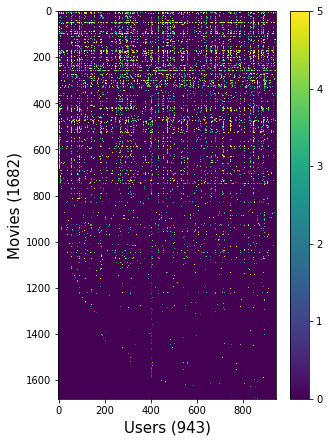

In [35]:
fig = plt.figure(figsize=(5, 4*(Y.shape[0] / Y.shape[1])))
plt.imshow(Y)
plt.colorbar()
plt.ylabel('Movies ({0})'.format(R.shape[0]), fontsize = 15)
plt.xlabel('Users ({0})'.format(R.shape[1]), fontsize = 15)

The above picture is supposed to be a visualization of our $R$ matrix, but it's not very easy to interpret if you ask me.

Now let's load in our $X$ and $\Theta$ matrices.

### Movie ratings dataset

![X and Theta](pic1.png)

In [36]:
params = loadmat('data/ex8_movieParams.mat')
X3 = params['X']
Theta = params['Theta']

In [37]:
print('X3: {0}'.format(X3.shape))
print('Theta: {0}'.format(Theta.shape))

X3: (1682, 10)
Theta: (943, 10)


### Collaborative Filtering Learning Algorithm
![2](pic2.png)
![3](pic3.png)

### Collaborative Filtering Cost Function
So... the time has come to do some more intense math. We need to code up $J$ our cost function, which we define as

$$J(x^{(i)},...,x^{(n_m)},\Theta^{(I)},...,\Theta^{(n_u)}) = \frac{1}{2} \sum ((\Theta^{(j)})^Tx^{(i)} - y^{(i,j)})^2 + (\frac{\lambda}{2} \sum^{n_u}_{j=1}\sum^n_{k=1} (\Theta^{(j)}_k)^2) + (\frac{\lambda}{2} \sum^{n_m}_{i=1}\sum^n_{k=1} (x^{(i)}_k)^2)$$


### Collaborative Filtering Gradient
Then, in order to minimize $J$, we need to calculate the partial derivatives of $J$ with respect to each $x^{(i)}_k$ and $\Theta^{(j)}_k$, which are given as

$$\frac{\partial J}{\partial x^{(i)}_k} = \sum ((\theta^{(j)})^Tx^{(i)} - y^{(i,j)})\theta_k^{(j)} +\lambda x^{(i)}_k$$

$$\frac{\partial J}{\partial \theta^{(j)}_k} = \sum ((\theta^{(j)})^Tx^{(i)} - y^{(i,j)})x_k^{(i)} +\lambda \theta^{(j)}_k$$

where $\lambda$ is a regularization parameter to keep us from overfitting. I find it better to do it all in one fell swoop! And remember! We vectorize to speed our code up.

In [40]:
def cost(params, Y, R, users, movies, features, reg):    
    X = params[: movies * features].reshape(movies, features)
    Theta = params[movies * features:].reshape(users, features)
    
    predictions =  X @ Theta.T
    loss = (predictions - Y)
    J = np.sum((np.square(loss) * R)) / 2
    
    # Cost regularization
    r_X =  reg / 2 * np.sum(np.square(Theta))
    r_Theta = reg / 2 * np.sum(np.square(X))
    J = J + r_X + r_Theta
    
    # gradient
    X_grad = loss * R @ Theta
    Theta_grad = (loss * R).T @ X
    grad = np.concatenate((X_grad.ravel(), Theta_grad.ravel()))
    
    # gradient regularization
    r_X_grad = X_grad + reg * X
    r_Theta_grad = Theta_grad + reg * Theta
    grad = np.concatenate((r_X_grad.ravel(), r_Theta_grad.ravel()))
    
    return J, grad

Now we can take the cost function for a spin and hope it doesn't crash. Given the data and parameters we're setting up below, Andrew Ng says to expect an output of 22.22 if we don't use regularization and 31.34 if we set $\lambda = 1.5$. 


In [41]:
# Cost function trial
num_users = 4; num_movies = 5; num_features = 3
X_test = X3[:num_movies,: num_features]
Theta_test = Theta[: num_users, : num_features]
Y_test = Y[: num_movies,: num_users]
R_test = R[: num_movies,: num_users]
params = np.concatenate((X_test.ravel(), Theta_test.ravel()))
params = params.reshape(len(params), 1)
print('X_test: {0}  Theta_test: {1}  Y_test: {2}  R_test: {3}  params: {4}'.format(X_test.shape, Theta_test.shape, 
                                                                            Y_test.shape, R_test.shape, params.shape))

X_test: (5, 3)  Theta_test: (4, 3)  Y_test: (5, 4)  R_test: (5, 4)  params: (27, 1)


In [42]:
# Cost function evalutaion
J = cost(params, Y_test, R_test, num_users, num_movies, num_features, 0)[0]
print("Trial cost with no regularization: {0}".format(J))
r_J = cost(params, Y_test, R_test, num_users, num_movies, num_features, 1.5)[0]
print("Trial cost with lambda = 1.5: {0}".format(r_J))

Trial cost with no regularization: 22.224603725685675
Trial cost with lambda = 1.5: 31.34405624427422


### Movie recommendations
Perfect! Now let's load up the movie names that actually appear in our ratings matrices.

In [45]:
with open('data/movie_ids.txt', 'rt',  encoding = "ISO-8859-1") as f:
    movies_lst = [line.strip() for line in f]

In [46]:
print("First 5 movies: {0}".format(movies_lst[: 5]))

First 5 movies: ['1 Toy Story (1995)', '2 GoldenEye (1995)', '3 Four Rooms (1995)', '4 Get Shorty (1995)', '5 Copycat (1995)']


Now we can rate some movies so that the algorithm can make some recommendations for us. I will use the default ratings that appear in the exercise so that the algorithm will output ratings consistently. These rating don't necessarily reflect my own preferences... in fact I outright disagree with several of them. For your reference, dear reader, here are the default ratings from the exercise:

![3](pic4.png)

2 for Silence of the Lambs?! honestly...

Feel free to play with the ratings below to reflect your own tastes and see what movies the algorithm recommends for you!

In [71]:
my_ratings = np.zeros((1682, 1))
my_ratings[0]   = 4
my_ratings[6]   = 3
my_ratings[11]  = 5
my_ratings[53]  = 4
my_ratings[63]  = 5
my_ratings[65]  = 3
my_ratings[68]  = 5
my_ratings[97]  = 2
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

Now we can alter the $Y$ and $R$ matrices to reflect the new ratings information.

In [72]:
Y = np.hstack((my_ratings, Y))
R = np.hstack((my_ratings != 0, R))
num_movies, num_users = Y.shape
num_features = 10
print("Y: {0}  R: {1}".format(Y.shape, R.shape))

Y: (1682, 945)  R: (1682, 945)


### Normalize Ratings
We need to do a little bit of preprocessing now by normalizing the ratings. We have to do this because if we get a user who hasn't rated any movies, then the algorithm will assume they rate every movie as 0. Instead, we'll just assume that the average rating for each movie reflects such a user's preference.

In [73]:
def normalizeRatings(Y, R):
    
    Y_mean = np.sum(Y, axis = 1) / np.sum(R, axis = 1)
    Y_mean = Y_mean.reshape((Y_mean.shape[0], 1))
    Y_norm = Y - Y_mean
    
    return Y_norm, Y_mean

In [74]:
Y_norm, Y_mean = normalizeRatings(Y, R)
print("Y_norm: {0}, Y_mean: {1}.".format(Y_norm.shape, Y_mean.shape))

Y_norm: (1682, 945), Y_mean: (1682, 1).


### Run Collaborative Filtering

Now we can randomly intialize a placeholder matrix for both $X$ and $\Theta$ and then unroll and combine them into one long vector. We do this to use scipy's optimization functionality so we can update these values with optimal choices and get the best possible model. We'll also use a $\lambda$ value of 10, as is used in the exercise.

In [75]:
X_ = np.random.rand(num_movies, num_features)
Theta_ = np.random.rand(num_users, num_features)
vect = np.concatenate((X_.ravel(), Theta_.ravel()))
vect = vect.reshape(len(vect), 1)
reg_ = 10
print("X_: {0}, Theta_: {1}, vect: {2}.".format(X_.shape, Theta_.shape, vect.shape))

X_: (1682, 10), Theta_: (945, 10), vect: (26270, 1).


Let's fire up scipy by passing it our cost function and all the related variables.

In [76]:
from scipy.optimize import minimize
res = minimize(fun = cost, x0 = vect, args = (Y, R, num_users, num_movies, num_features, reg_), 
               method = 'TNC', jac = True, options={'maxiter': 1500})
res

     fun: 71923.74970756333
     jac: array([ 4.44500245e-05,  2.05950778e-05,  4.57956392e-06, ...,
       -8.42837624e-07, -8.25972959e-07, -4.68450505e-06])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 1163
     nit: 41
  status: 1
 success: True
       x: array([0.09381149, 0.66191706, 0.04587381, ..., 0.87447635, 0.65665284,
       0.67161268])

Sweet, sweet convergence! Scipy outputs a solution vector with optimized values for our parameters. From this long vector, we need to recover our $X$ and $\Theta$ matrices so we can make our predictions. 

In [77]:
res_X = res.x[:num_movies * num_features].reshape(num_movies, num_features)
res_Theta = res.x[num_movies * num_features:].reshape(num_users, num_features)
print('res_X: {0}, res_Theta: {1}'.format(res_X.shape, res_Theta.shape))

res_X: (1682, 10), res_Theta: (945, 10)


Then we just multiply these to matrices together to get a new matrix of the actual predictions.

In [78]:
prediction_matrix =  res_X.dot(res_Theta.T)
print('prediction_matrix: {0}'.format(prediction_matrix.shape))

prediction_matrix: (1682, 945)


I swear this is almost over! The final computation will be grabbing the ratings we actually made from the matrix and then adding the mean so there are no zero ratings.

In [79]:
preds = prediction_matrix[:, 0][:, np.newaxis] + Y_mean
print('preds: {0}'.format(preds.shape))

preds: (1682, 1)


Now we can make a pandas dataframe with the predictions and movies sorted by highest rated to lowest.

In [80]:
import pandas as pd
df = pd.DataFrame(np.hstack((preds, np.array(movies_lst)[:, np.newaxis])))
df.sort_values(by = [0], ascending = False, inplace = True)
df.reset_index(drop = True, inplace = True)
df.columns = ['ratings', 'movies']
df.head()

,ratings,movies
0,8.551072156655675,313 Titanic (1997)
1,8.510537128299813,50 Star Wars (1977)
2,8.308065804081895,"64 Shawshank Redemption, The (1994)"
3,8.242556826564448,174 Raiders of the Lost Ark (1981)
4,8.1811116676894,318 Schindler's List (1993)


In [81]:
df.tail()

,ratings,movies
1677,1.0677060144977664,1546 Shadows (Cienie) (1988)
1678,1.06770598775689,1557 Yankee Zulu (1994)
1679,1.0677058887735404,"1583 Invitation, The (Zaproszenie) (1986)"
1680,1.0677058596971827,"1575 I, Worst of All (Yo, la peor de todas) (1..."
1681,1.067704703143501,1580 Liebelei (1933)


I've never even heard of those films...

We're done! Let's see what movies the algorithm recommends for us based on the default ratings from the exercise.

In [83]:
print("Top recommendations for you:")
for i in np.arange(10):
    print("Predicting rating {0} for index {1}.".format(round(float(df['ratings'][i]),1), df['movies'][i]))
print()    
print("Original ratings provided:")
for i in np.arange(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated {0} for movie {1}.'.format(my_ratings[i][0], movies_lst[i]))

Top recommendations for you:
Predicting rating 8.6 for index 313 Titanic (1997).
Predicting rating 8.5 for index 50 Star Wars (1977).
Predicting rating 8.3 for index 64 Shawshank Redemption, The (1994).
Predicting rating 8.2 for index 174 Raiders of the Lost Ark (1981).
Predicting rating 8.2 for index 318 Schindler's List (1993).
Predicting rating 8.2 for index 272 Good Will Hunting (1997).
Predicting rating 8.1 for index 172 Empire Strikes Back, The (1980).
Predicting rating 8.0 for index 12 Usual Suspects, The (1995).
Predicting rating 8.0 for index 22 Braveheart (1995).
Predicting rating 8.0 for index 127 Godfather, The (1972).

Original ratings provided:
Rated 4.0 for movie 1 Toy Story (1995).
Rated 3.0 for movie 7 Twelve Monkeys (1995).
Rated 5.0 for movie 12 Usual Suspects, The (1995).
Rated 4.0 for movie 54 Outbreak (1995).
Rated 5.0 for movie 64 Shawshank Redemption, The (1994).
Rated 3.0 for movie 66 While You Were Sleeping (1995).
Rated 5.0 for movie 69 Forrest Gump (1994).
R

This matches the expected output almost exactly. It's a little different because of random intialization, but that's to be expected, as Andrew Ng says. Well, dear reader, we've finished the assignment, but we can also use scikit learn to implement a recommender system.

### Recommender System with Scikit Learn

Here, we'll use the brand new surprise library from scikit learn to make movie recommendations using singular value decomposition (SVD). Let's do some importing!

In [84]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from collections import defaultdict
from surprise import SVD as SVD

To do something a little more interesting, let's make up a bunch of users and randomly assign them to random movies. We'll do this by making a list of random choices and then just adding this list to our dataframe from earlier.

In [86]:
import random
names = ['Julius', 'Tim', 'Derek', 'Hyein', 'Tobin', 'Richard', 'Catherine', 'Eric', 'Bre', 'Lawton']
users = []
while len(users) != len(df):
    users.append(random.choice(names))
df['users'] = users
df.head()

,ratings,movies,users
0,8.551072156655675,313 Titanic (1997),Richard
1,8.510537128299813,50 Star Wars (1977),Bre
2,8.308065804081895,"64 Shawshank Redemption, The (1994)",Tim
3,8.242556826564448,174 Raiders of the Lost Ark (1981),Tobin
4,8.1811116676894,318 Schindler's List (1993),Hyein


In [87]:
df.tail()

,ratings,movies,users
1677,1.0677060144977664,1546 Shadows (Cienie) (1988),Tim
1678,1.06770598775689,1557 Yankee Zulu (1994),Catherine
1679,1.0677058887735404,"1583 Invitation, The (Zaproszenie) (1986)",Derek
1680,1.0677058596971827,"1575 I, Worst of All (Yo, la peor de todas) (1...",Eric
1681,1.067704703143501,1580 Liebelei (1933),Lawton


In [88]:
#reorder columns for surprise
df = df[['users', 'movies', 'ratings']]
df.head()

,users,movies,ratings
0,Richard,313 Titanic (1997),8.551072156655675
1,Bre,50 Star Wars (1977),8.510537128299813
2,Tim,"64 Shawshank Redemption, The (1994)",8.308065804081895
3,Tobin,174 Raiders of the Lost Ark (1981),8.242556826564448
4,Hyein,318 Schindler's List (1993),8.1811116676894


Surprise has a couple of idiosyncrasies, such as its own reader, data, trainset, and testset object. Thankfully they mesh well with a pandas dataframe, so making these new objects is no big deal.

In [90]:
reader = Reader(rating_scale = (1, 10))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['users', 'movies', 'ratings']], reader)
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

Let's train our SVD algorithm on the training data and have it make some predictions on the test data.

In [94]:
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

Finally, we just need a function that will link each prediction to a user and then sort them based on the highest ratings.

In [95]:
def topN(predictions, n):
    # map the predictions to each user.
    top_n = defaultdict(list)
    for user, item, rating, est, _ in predictions:
        top_n[user].append((item, est))

    # Sort predictions for each user and retrieve the n highest ones.
    for user, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[user] = user_ratings[:n]

    return top_n

And let's have the algorithm give us the top 10 predictions for each user.

In [97]:
top_n = topN(predictions, 10)
df2 = pd.DataFrame()


for user, user_ratings in top_n.items():
    df2[user] = [item for (item, _) in user_ratings]
df2

,Richard,Bre,Tim,Tobin,Hyein,Lawton,Eric,Derek,Julius,Catherine
0,291 Absolute Power (1997),22 Braveheart (1995),1120 I'm Not Rappaport (1996),"596 Hunchback of Notre Dame, The (1996)",223 Sling Blade (1996),"587 Hour of the Pig, The (1993)",357 One Flew Over the Cuckoo's Nest (1975),921 Farewell My Concubine (1993),626 So Dear to My Heart (1949),272 Good Will Hunting (1997)
1,1356 Ed's Next Move (1996),811 Thirty-Two Short Films About Glenn Gould (...,628 Sleepers (1996),419 Mary Poppins (1964),313 Titanic (1997),"153 Fish Called Wanda, A (1988)","85 Ref, The (1994)",174 Raiders of the Lost Ark (1981),537 My Own Private Idaho (1991),471 Courage Under Fire (1996)
2,"748 Saint, The (1997)",273 Heat (1995),923 Raise the Red Lantern (1991),183 Alien (1979),1131 Safe (1995),"172 Empire Strikes Back, The (1980)",134 Citizen Kane (1941),1267 Clockers (1995),"111 Truth About Cats & Dogs, The (1996)",725 Exit to Eden (1994)
3,15 Mr. Holland's Opus (1995),1272 Talking About Sex (1994),"503 Candidate, The (1972)",109 Mystery Science Theater 3000: The Movie (1...,517 Manhattan (1979),1194 Once Were Warriors (1994),527 Gandhi (1982),202 Groundhog Day (1993),198 Nikita (La Femme Nikita) (1990),"520 Great Escape, The (1963)"
4,"115 Haunted World of Edward D. Wood Jr., The (...","1158 Fille seule, La (A Single Girl) (1995)","169 Wrong Trousers, The (1993)","580 Englishman Who Went Up a Hill, But Came Do...",1245 Gridlock'd (1997),"519 Treasure of the Sierra Madre, The (1948)",427 To Kill a Mockingbird (1962),83 Much Ado About Nothing (1993),96 Terminator 2: Judgment Day (1991),270 Gattaca (1997)
5,196 Dead Poets Society (1989),237 Jerry Maguire (1996),"879 Peacemaker, The (1997)","72 Mask, The (1994)",60 Three Colors: Blue (1993),1278 Selena (1997),1212 Flesh and Bone (1993),1457 Love Is All There Is (1996),109 Mystery Science Theater 3000: The Movie (1...,385 True Lies (1994)
6,134 Citizen Kane (1941),1117 Surviving Picasso (1996),39 Strange Days (1995),"448 Omen, The (1976)",82 Jurassic Park (1993),"1191 Letter From Death Row, A (1998)",1526 Witness (1985),740 Jane Eyre (1996),"163 Return of the Pink Panther, The (1974)",257 Men in Black (1997)
7,591 Primal Fear (1996),372 Jeffrey (1995),182 GoodFellas (1990),691 Dark City (1998),754 Red Corner (1997),"459 Cry, the Beloved Country (1995)","193 Right Stuff, The (1983)","615 39 Steps, The (1935)",19 Antonia's Line (1995),58 Quiz Show (1994)
8,"1051 Associate, The (1996)",100 Fargo (1996),"25 Birdcage, The (1996)",735 Philadelphia (1993),262 In the Company of Men (1997),210 Indiana Jones and the Last Crusade (1989),1600 Guantanamera (1994),694 Persuasion (1995),632 Sophie's Choice (1982),819 Eddie (1996)
9,"510 Magnificent Seven, The (1954)",309 Deceiver (1997),"1097 Hate (Haine, La) (1995)",242 Kolya (1996),803 Heaven & Earth (1993),152 Sleeper (1973),1387 Fall (1997),346 Jackie Brown (1997),"977 Substitute, The (1996)","484 Maltese Falcon, The (1941)"


Pretty cool! Of course, because we did this randomly, we have no way of knowing how accurate these predictions are, but this example is instructive as to how we might implement such an algorithm in a real world setting.  At any rate, I hope this was helpful to you, dear reader.